In [1]:
from forward_solver import SteadyHeatForwardSolver2D

## Define domain


In [2]:
nmesh=64
mesh_type='quadrilateral'

## Define thermal conductivity

In [3]:
# spatially-varying thermal conductivity
def h_func(x):
    return 1E-2 + 6e-2*x[0]**2 + 1e-2*x[0]/(1.0 + 2.0*x[1]**2)

## Define heat source

In [4]:
q=1.0 # constant heat source

## Define boundary condition

In [5]:
T_bottom=300. # in Kelvin, Dirichlet boundary condition on the bottom

## Initialize solver

In [6]:
blackbox_solver=SteadyHeatForwardSolver2D(nmesh=nmesh, mesh_type=mesh_type, \
                                          h=h_func, q=q,\
                                          DBC_value=T_bottom)

## Solve

In [7]:
blackbox_solver.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, [])), 1)

## Visualize output $T(x,y)$

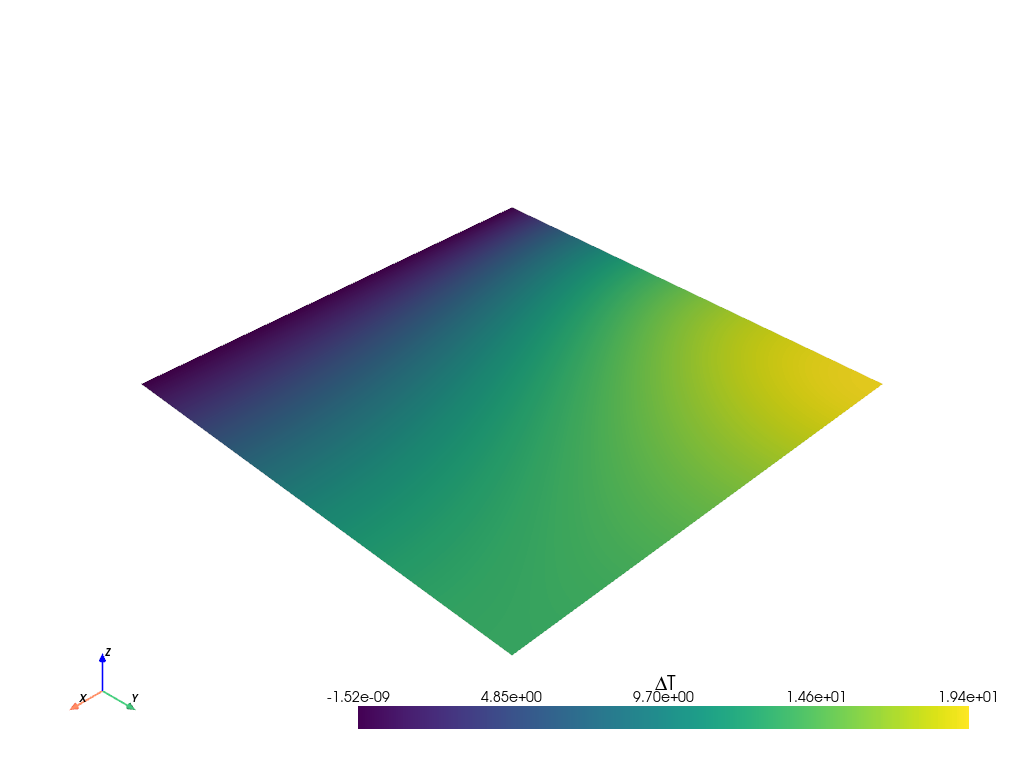

In [8]:
blackbox_solver.plot()